# 1. Import Library

In [1]:
# Setup notebook
from pathlib import Path
import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess


# 2. Load Dataset

            unemployed
date                  
2010-01-01     436.739
2010-02-01     427.400
2010-03-01     428.300
2010-04-01     378.505
2010-05-01     398.700


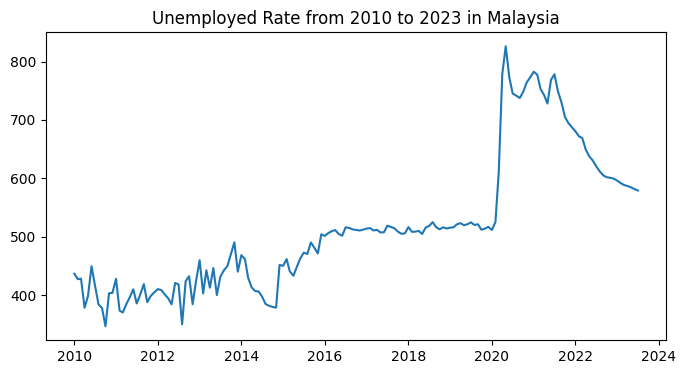

In [3]:
# import data set
data_dir = Path('../datathon')

# read data set
df = pd.read_csv(data_dir / 'labourforce_monthly.csv', parse_dates=['date'])
df.head()

# remove the empty columns
df = df.dropna(axis=1, how='all')

# Remove all the unnecessary columns only left the date and unemployed columns
df = df[['date', 'unemployed']]
df.index = df.date
data_date = df.date

# plot the data set
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(df.date, df.unemployed, label='train')

# add title and legend to the plot
plt.title('Unemployed Rate from 2010 to 2023 in Malaysia')

# remove date column in df
df = df.drop('date', axis=1)

print(df.head())

# 4. Split the Data set into train and test set

In [9]:
import matplotlib.pyplot as plt
# split the data set into train and test
train = df[df.index < '2019-01-01']
test = df[df.index >= '2019-01-01']
train.shape, test.shape


((108, 1), (55, 1))

# 5. Linear Regression with Regression

TypeError: object of type 'NoneType' has no len()

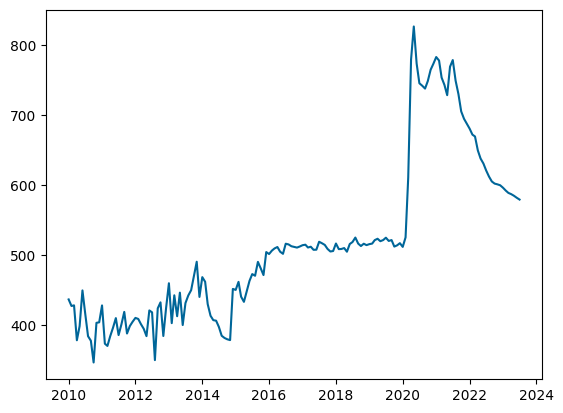

In [22]:
# make the regression plot
fig, ax = plt.subplots()
ax.plot("unemployed", data = df, label='observed', color='#006699')
ax = sns.regplot(y="unemployed", data = df, label='trend', color='#ff6600')
ax.set_title('Time Plot of Unemployment rate from 2010 to 2019 in Malaysia')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate')
plt.show()